# Statystyki Koronawirusa

Autor: Filip Paluszak

Projekt ma na celu wizualizacje statystyk nt. koronawirusa w Polsce. 
Dane pobrane są z https://www.gov.pl/web/koronawirus/wykaz-zarazen-koronawirusem-sars-cov-2

Ponieważ strona rzadowa zmieniała się kilka razy w ciągu paru miesięcy, dane nie były scrapowane, ale pobrane statycznie

## Instalacja

1) Instalacja geopandas https://www.hatarilabs.com/ih-en/how-to-install-python-geopandas-on-anaconda-in-windows-tutorial

2) pip install -r requirements.txt

## Ladowanie Danych

### Dane statystyczne

Dane załadowane są z plików csv. Niestety kodowania plików są różne (mimo że pochodzą z jednego źródła), więc trzeba obsługiwać błędy kodowania

In [1]:
import os

from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd

In [2]:
# Wczytujemy dane ze wszystkich plikow
def read_data(data_dir):
    df_list = []
    for path, _, filenames in os.walk(data_dir):
        for f in filter(lambda x: x.endswith('.csv'), filenames):
            filepath = os.path.join(path, f)
            for enc in ["utf-8", "cp1250"]:
                try:
                    df_list.append(pd.read_csv(os.path.join(path, f), encoding=enc, delimiter=';'))
                    break
                except Exception as e:
                    pass
            else:
                print(f'Nie udało się wczytać {filepath}')
    return pd.concat(df_list)
        

In [3]:
df = read_data('data')
# Usuwamy statystyki dla całego kraju
df = df[df['wojewodztwo'] != 'Cały kraj']

# Usuwamy wiersze bez daty
df = df.dropna(subset=['stan_rekordu_na'])

In [4]:
# Możliwe daty
available_dates = df['stan_rekordu_na'].unique()
print(available_dates)
len(available_dates)

['2020-11-23' '2020-11-24' '2020-11-25' '2020-11-26' '2020-11-27'
 '2020-11-28' '2020-11-29' '2020-11-30' '2020-12-01' '2020-12-02'
 '2020-12-03' '2020-12-04' '2020-12-05' '2020-12-06' '2020-12-07'
 '2020-12-08' '2020-12-09' '2020-12-10' '2020-12-11' '2020-12-12'
 '2020-12-13' '2020-12-14' '2020-12-15' '2020-12-16' '2020-12-17'
 '2020-12-18' '2020-12-19' '2020-12-20' '2020-12-21' '2020-12-22'
 '2021-01-27' '2021-01-28' '2021-01-29' '2021-01-30' '2021-01-31'
 '2021-02-01' '2021-02-02' '2021-02-03' '2021-02-04' '2021-02-05'
 '2021-02-06' '2021-02-07' '2021-02-08' '2021-02-09' '2021-02-10'
 '2021-02-11' '2021-02-12' '2021-02-13' '2021-02-14' '2021-02-15'
 '2021-02-16']


51

In [5]:
# Mozliwe kolumny
pprint(list(df.columns))

['wojewodztwo',
 'powiat_miasto',
 'liczba_przypadkow',
 'liczba_na_10_tys_mieszkancow',
 'zgony',
 'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych',
 'zgony_w_wyniku_covid_i_chorob_wspolistniejacych',
 'liczba_zlecen_poz',
 'liczba_osob_objetych_kwarantanna',
 'liczba_wykonanych_testow',
 'liczba_testow_z_wynikiem_pozytywnym',
 'liczba_testow_z_wynikiem_negatywnym',
 'liczba_pozostalych_testow',
 'teryt',
 'stan_rekordu_na',
 'liczba_ozdrowiencow']


### Mapa z powiatami
Do wizualizacji posłużyłem się mapą powiatów
https://maten.pl/post/poland-map/

In [6]:
try:
    pl_powiaty = gpd.read_file('dane_geo\Powiaty.shp')
except ValueError as e:
    print(e)

(13.621739949250054, 24.646927985750057, 48.710328010550036, 55.12813517445003)

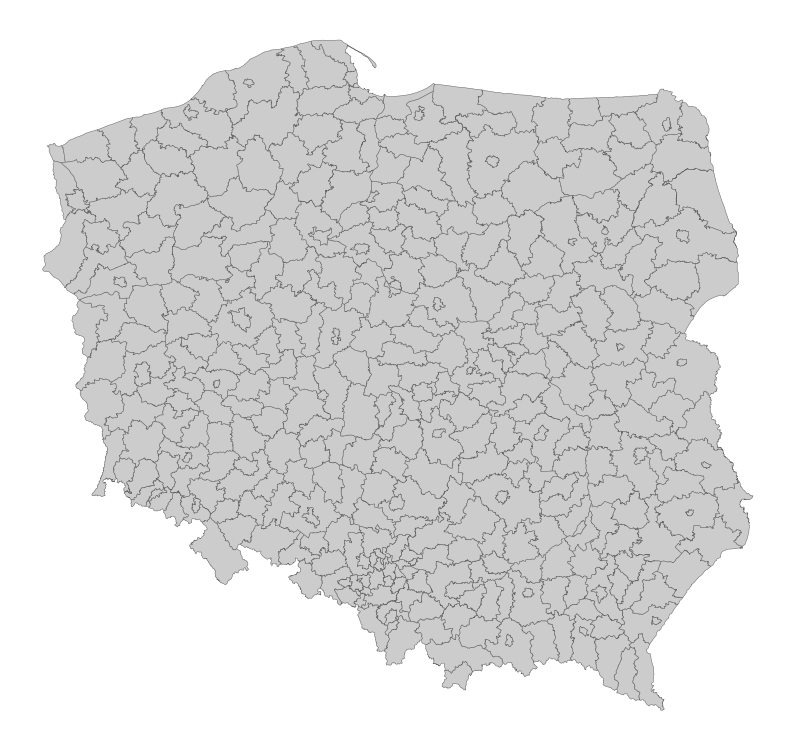

In [7]:
# Przykladowa pusta mapa z zaznaczonymi powiatami
fig, ax = plt.subplots(1, figsize=(14, 14))
pl_powiaty.plot(ax=ax, linewidth=0.5, edgecolor='0.4', color='0.8')
ax.axis('off')

## Łączenie danych
Aby wyświetlić dane na mapie, potrzebujemy połączyć dane na temat koronawirusa z mapą.
Będziemy łączyć po kodzie terytorialnym. Niestety formaty w danych nt koronawirusa i mapy się różnią, więc trzeba je uwspólnić

In [8]:
# Usuwamy pierwszą literke z kodu terytorialnego z danych csv
df['JPT_KOD_JE'] = df.apply(lambda x: x.teryt[1:], axis=1)

In [9]:
pl_powiaty_merged = pl_powiaty.merge(df, left_on='JPT_KOD_JE', right_on='JPT_KOD_JE')
pl_powiaty_merged.fillna(0, inplace=True)

In [10]:
pl_powiaty_merged.shape

(19380, 46)

## Wizualizacje

Pomocnicze funkcje do wizualizacji map i wykresow

In [11]:
# Pojedyncza mapa
def map_vis(df, column, date):
    if date not in available_dates:
        raise Exception(f'Zly zakres daty {date_1}')
    
    fig, ax = plt.subplots(1, figsize=(15, 15))

    df_1 = df[df['stan_rekordu_na'] == date]
    df_1.plot(ax=ax, linewidth=0.5, edgecolor='0.4', column=column, cmap='Greens', scheme='quantiles', legend=True)
    
    ax.set_title(f'{column} w dniu {date}')
    ax.axis('off')

In [12]:
# Porownanie dwoch map wzgledem daty
def map_vis_cmp_date(df, column, date_1, date_2):
    if date_1 not in available_dates:
        raise Exception(f'Zly zakres daty {date_1}')
    if date_2 not in available_dates:
        raise Exception(f'Zly zakres daty {date_2}')
        
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    
    df_1 = df[df['stan_rekordu_na'] == date_1]
    df_2 = df[df['stan_rekordu_na'] == date_2]
    
    df_1.plot(ax=ax1, linewidth=0.5, edgecolor='0.4', column=column, cmap='Greens', scheme='quantiles', legend=True)
    df_2.plot(ax=ax2, linewidth=0.5, edgecolor='0.4', column=column, cmap='Greens', scheme='quantiles', legend=True)
    
    ax1.set_title(f'{column} w dniu {date_1}')
    ax2.set_title(f'{column} w dniu {date_2}')
    
    ax1.axis('off')
    ax2.axis('off')

In [13]:
# Porownanie dwoch map wzgledem kolumn
def map_vis_cmp_columns(df, column_1, column_2, date):
    if date not in available_dates:
        raise Exception(f'Zly zakres daty {date}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
    
    df = df[df['stan_rekordu_na'] == date]
    
    df.plot(ax=ax1, linewidth=0.5, edgecolor='0.4', column=column_1, cmap='Greens', scheme='quantiles', legend=True)
    df.plot(ax=ax2, linewidth=0.5, edgecolor='0.4', column=column_2, cmap='Greens', scheme='quantiles', legend=True)
    
    ax1.set_title(f'{column_1} w dniu {date}')
    ax2.set_title(f'{column_2} w dniu {date}')
    
    ax1.axis('off')
    ax2.axis('off')

In [14]:
def bar_plot_wojewodztwa(df, column, date):
    fig, ax = plt.subplots(figsize=(8, 3), dpi=144)
    colors = plt.cm.Dark2(range(6))
    
    df2 = df[df['stan_rekordu_na'] == date].copy()
    df2 = df2.groupby(['wojewodztwo', 'stan_rekordu_na'], as_index=False)[column].agg(sum).reindex()
    df2.sort_values(column, inplace=True)
    
    y = df2.wojewodztwo
    width = df2[column]
    
    ax.barh(y=y, width=width, color=colors);

In [15]:
def wojewodztwo_line_plot(df, column):
    fig, ax = plt.subplots(figsize=(25, 10), dpi=144)

    df = df.groupby(['wojewodztwo', 'stan_rekordu_na'], as_index=False)[column].agg(sum).reindex()
    for wojewodztwo, df_w in df.groupby(['wojewodztwo']):
        x = df_w['stan_rekordu_na']
        y = df_w[column]
        ax.plot(x, y, label=wojewodztwo)

    ax.legend(bbox_to_anchor=(1.1, 1.05))
    fig.autofmt_xdate()

# Analiza

# Liczba Przypadkow

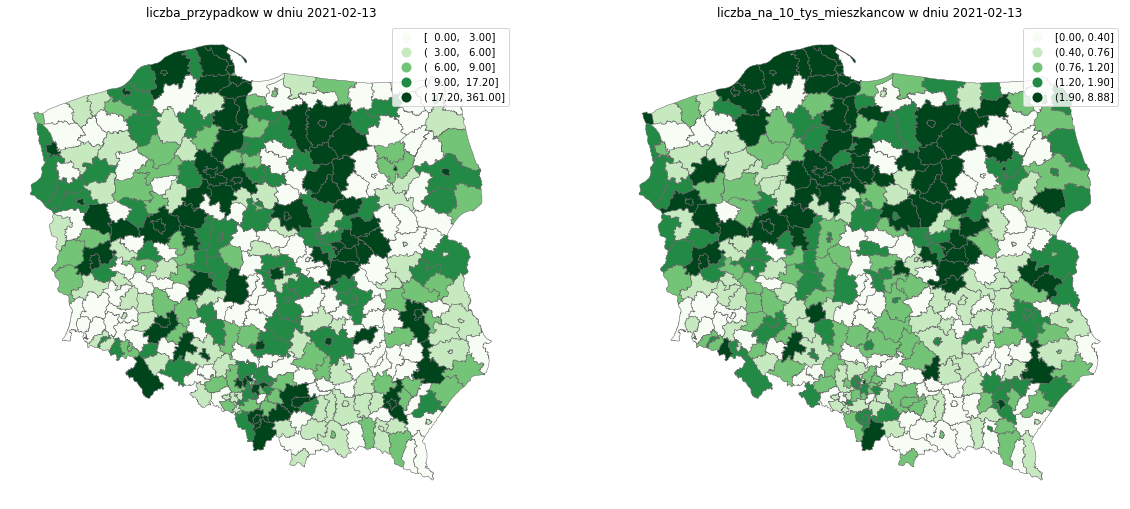

In [16]:
map_vis_cmp_columns(pl_powiaty_merged, 'liczba_przypadkow', 'liczba_na_10_tys_mieszkancow', '2021-02-13')

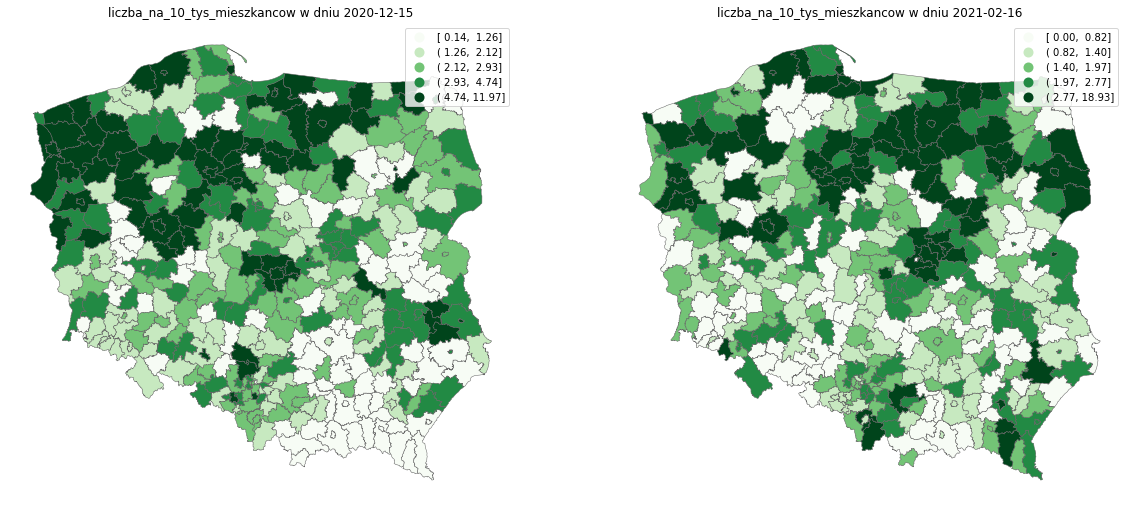

In [17]:
map_vis_cmp_date(pl_powiaty_merged, 'liczba_na_10_tys_mieszkancow', '2020-12-15', '2021-02-16')

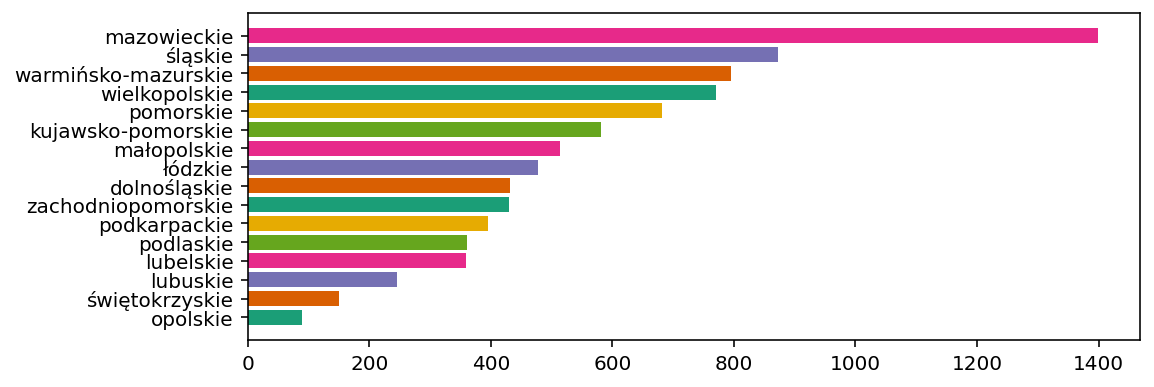

In [18]:
bar_plot_wojewodztwa(pl_powiaty_merged, 'liczba_przypadkow', '2021-02-16')

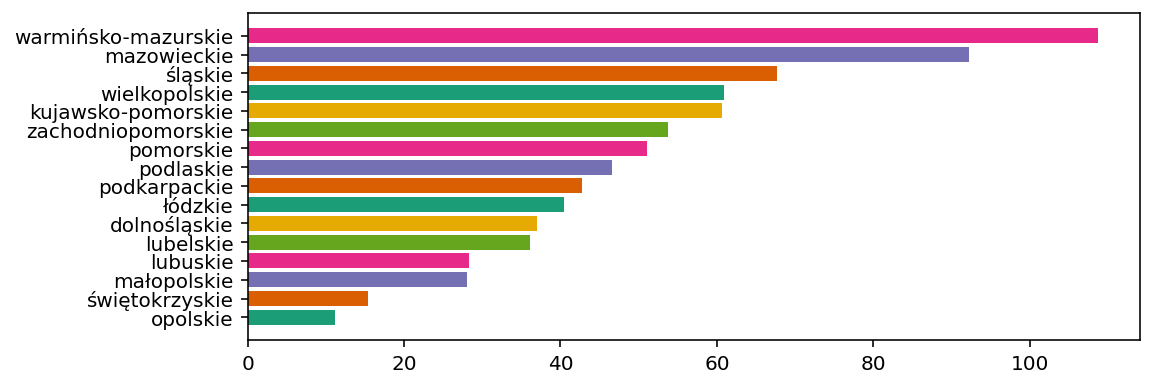

In [19]:
bar_plot_wojewodztwa(pl_powiaty_merged, 'liczba_na_10_tys_mieszkancow', '2021-02-16')

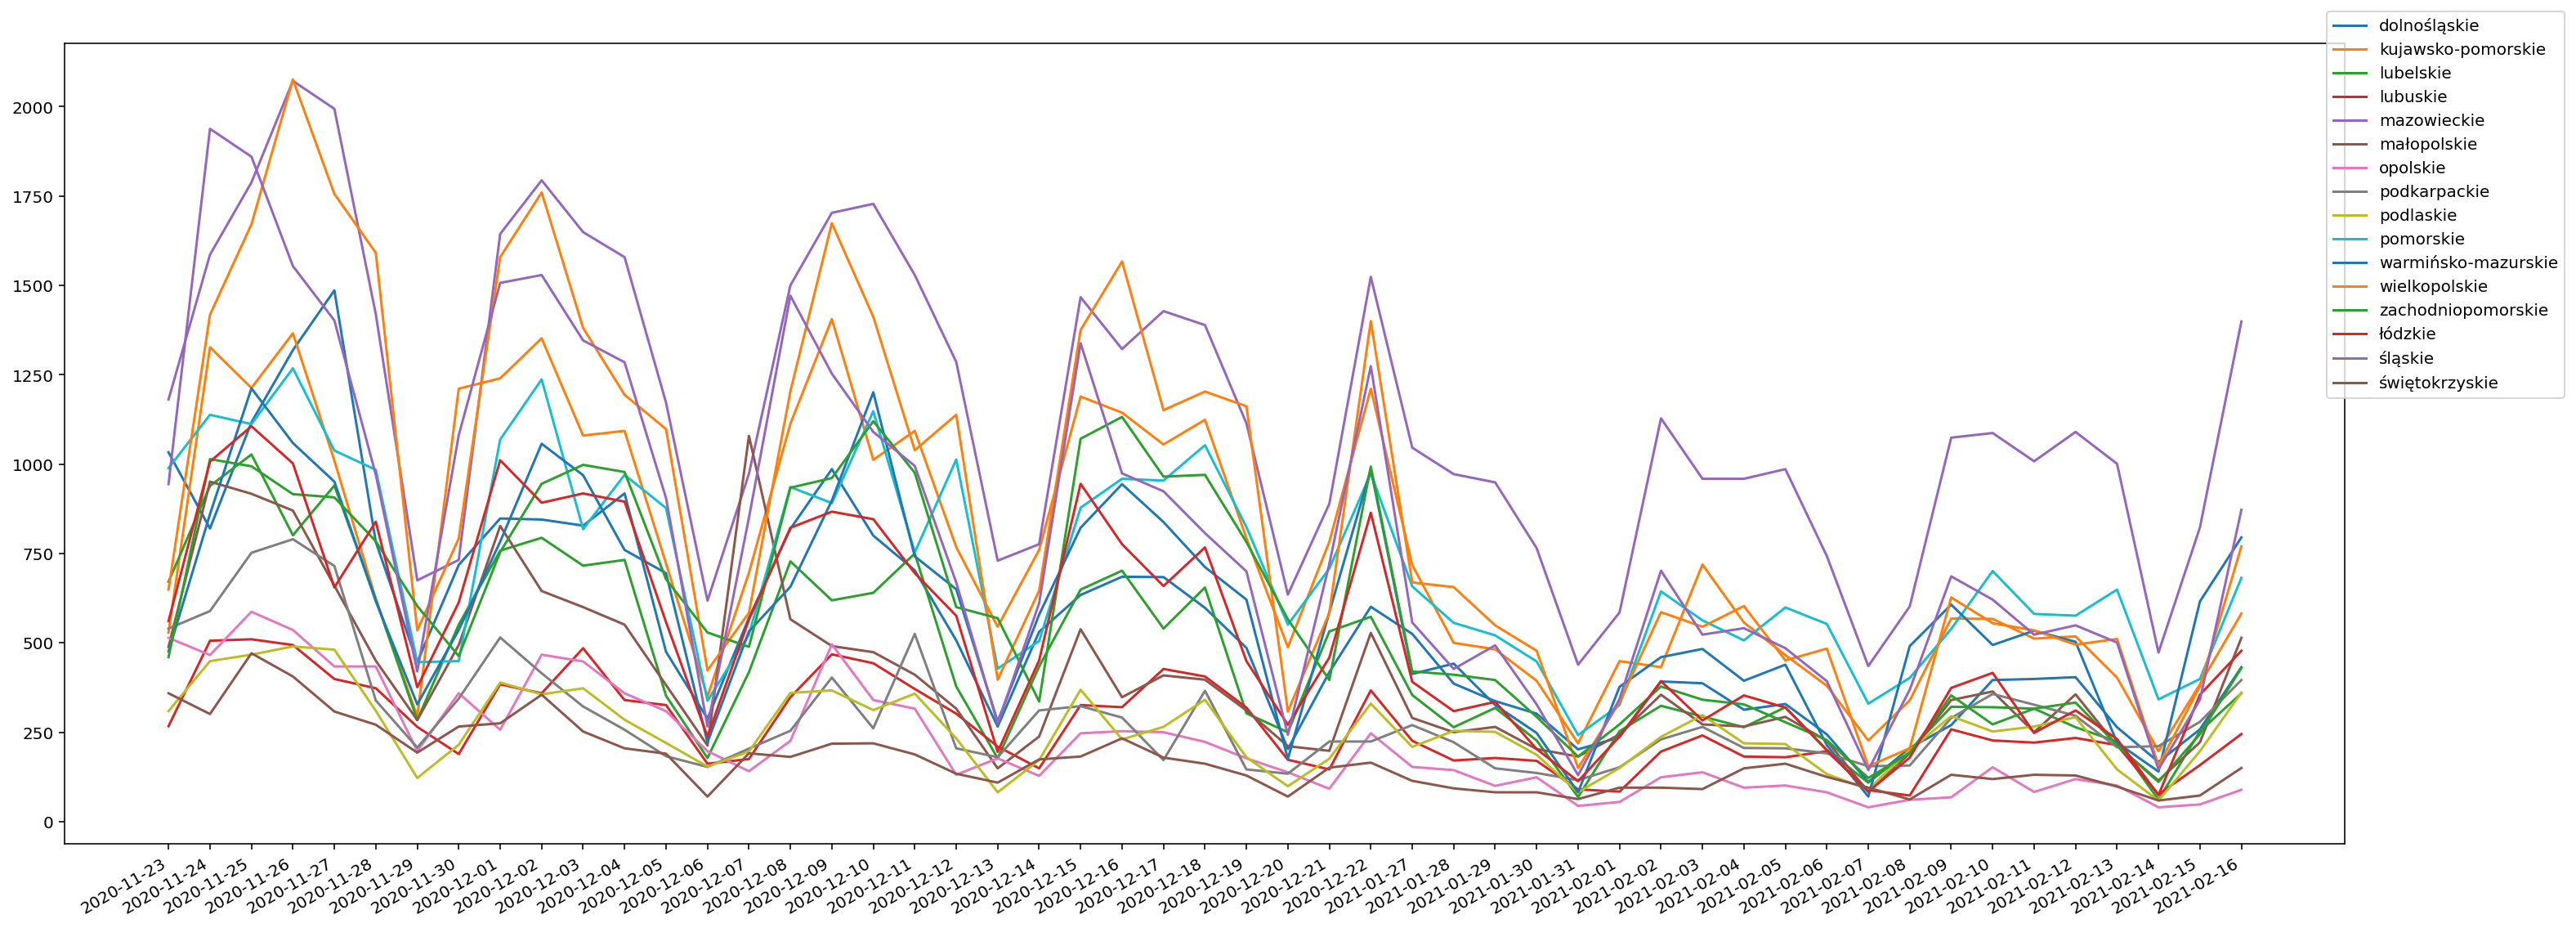

In [20]:
wojewodztwo_line_plot(pl_powiaty_merged, 'liczba_przypadkow')

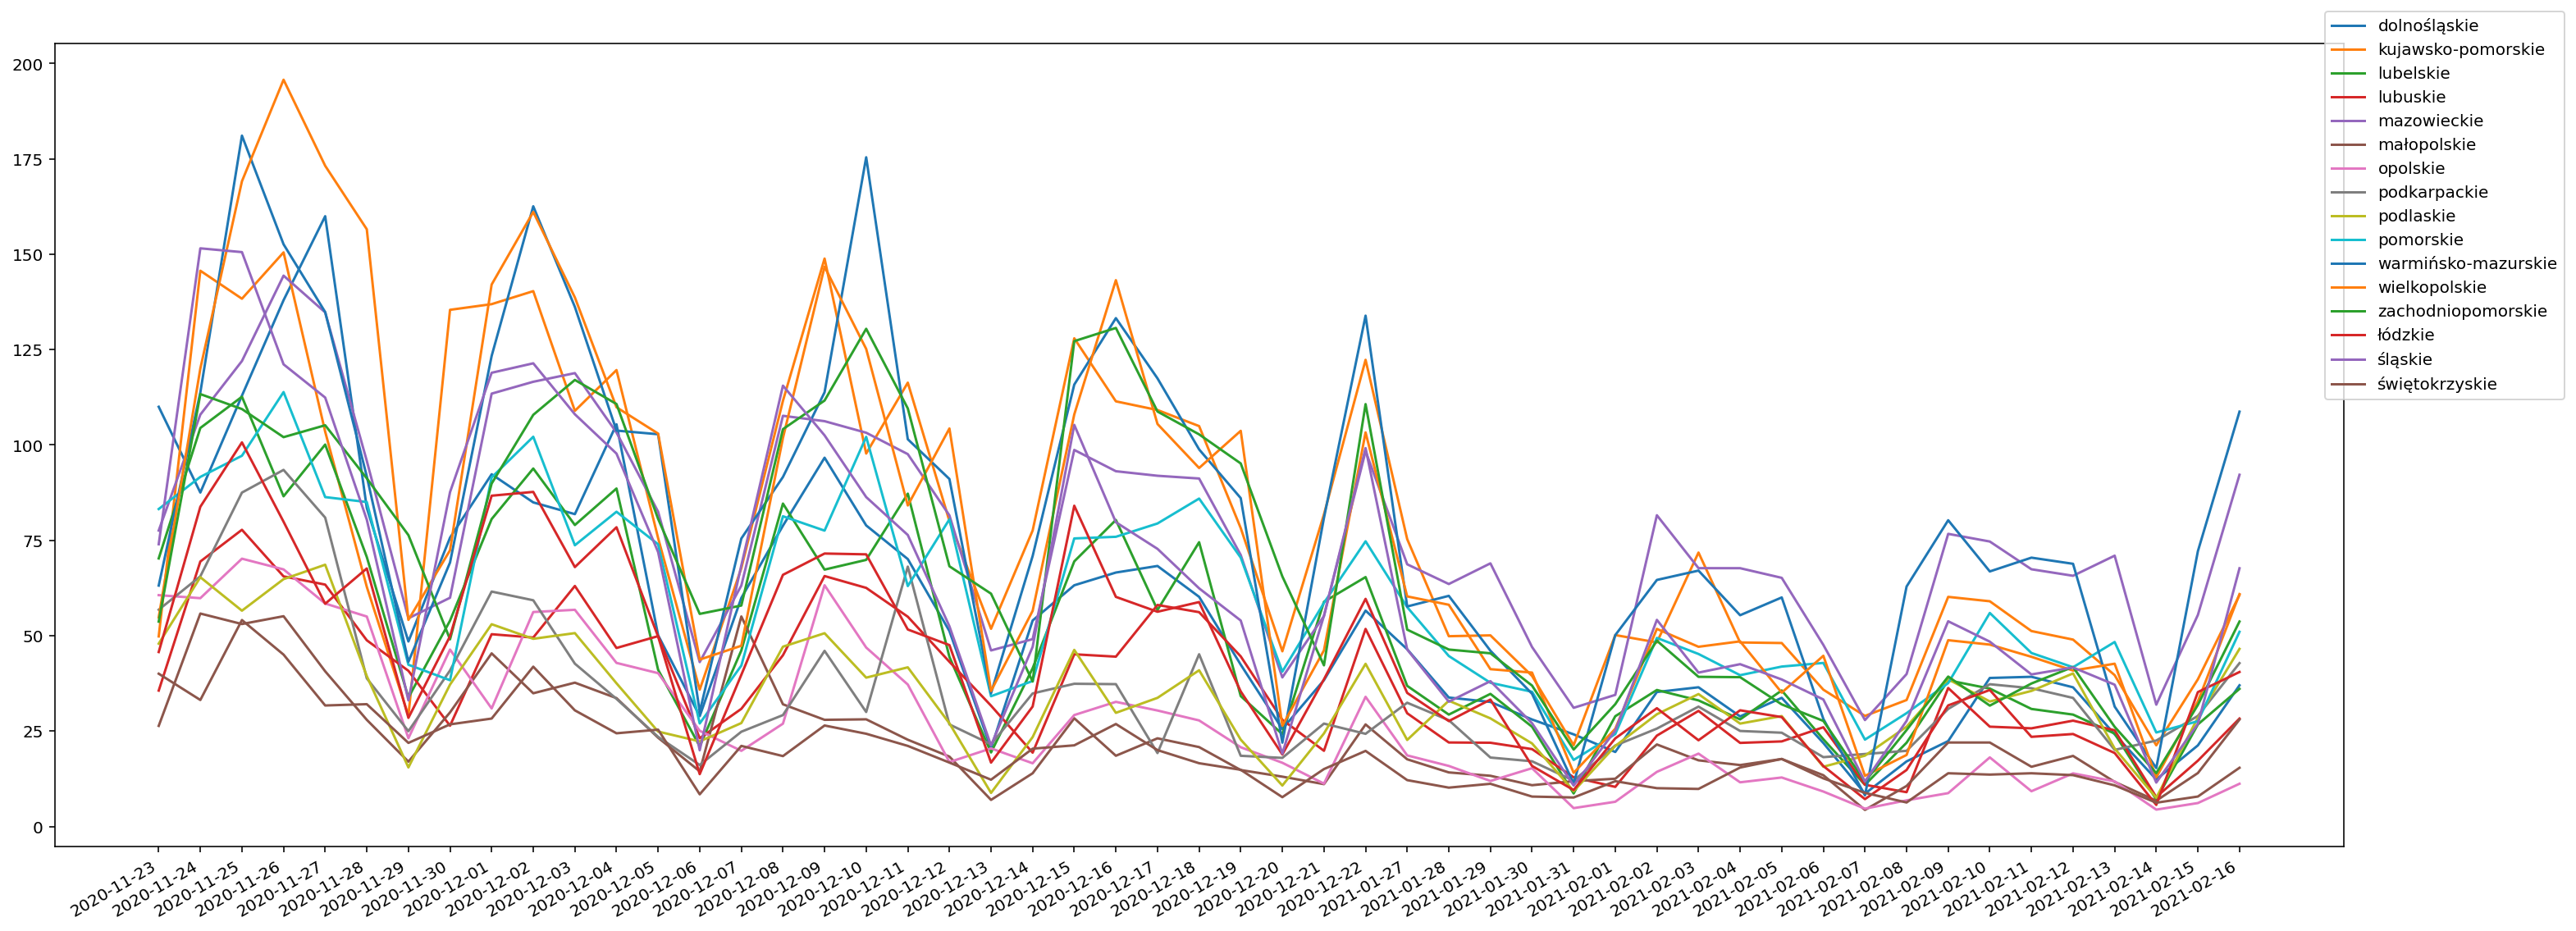

In [21]:
wojewodztwo_line_plot(pl_powiaty_merged, 'liczba_na_10_tys_mieszkancow')

## Ozdrowiency

Ponizej pokazujemy statystyki na temat rozkladu ozdrowienców

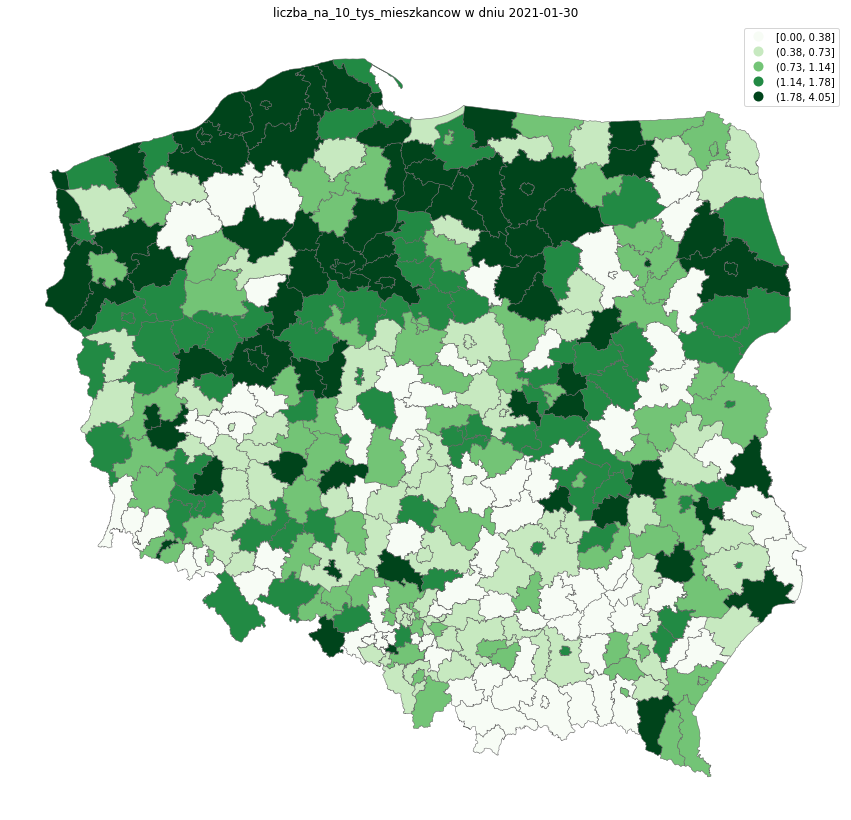

In [22]:
map_vis(pl_powiaty_merged, 'liczba_na_10_tys_mieszkancow', '2021-01-30')

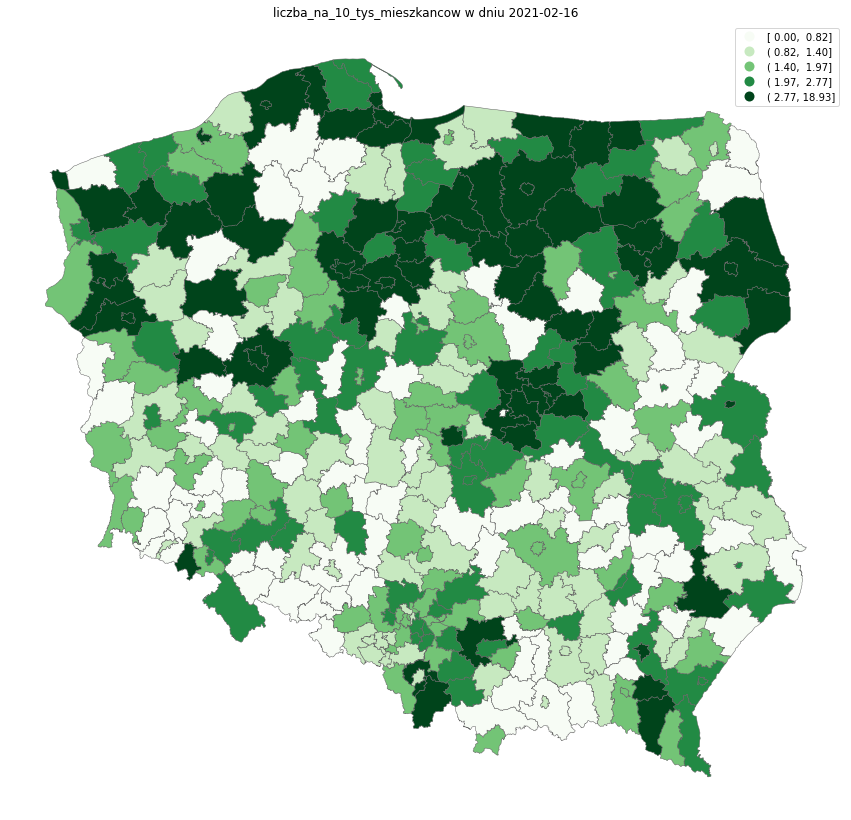

In [23]:
map_vis(pl_powiaty_merged, 'liczba_na_10_tys_mieszkancow', '2021-02-16')

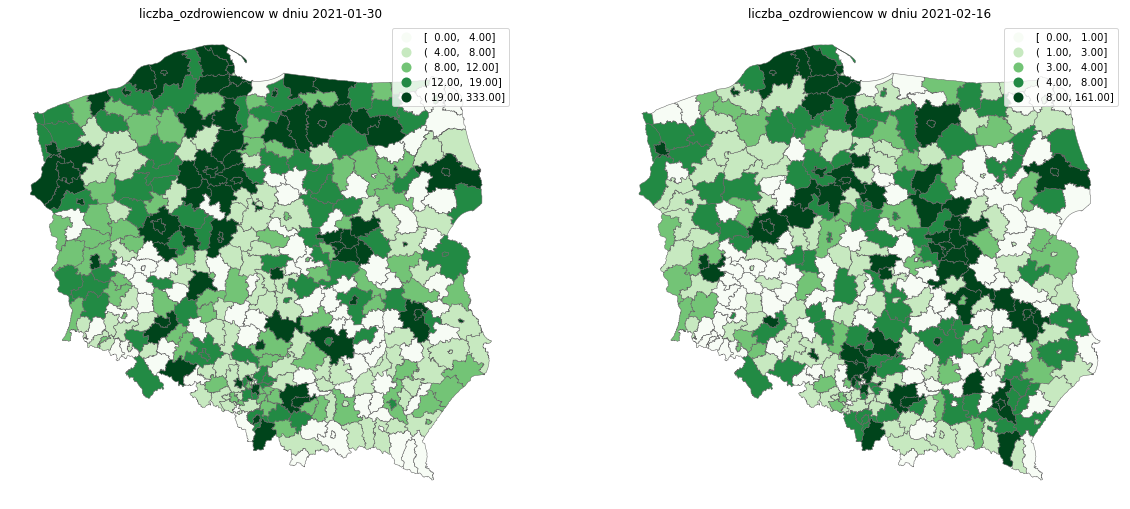

In [24]:
map_vis_cmp_date(pl_powiaty_merged, 'liczba_ozdrowiencow', '2021-01-30', '2021-02-16')

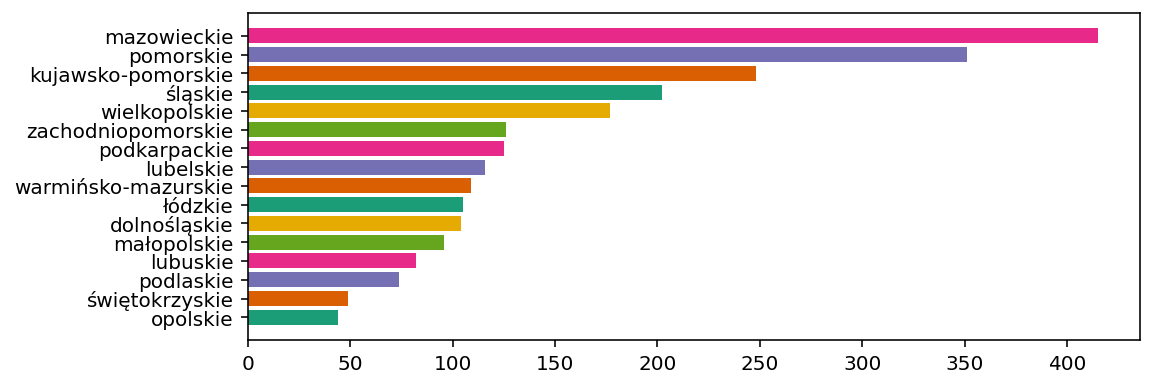

In [25]:
bar_plot_wojewodztwa(pl_powiaty_merged, 'liczba_ozdrowiencow', '2021-02-16')

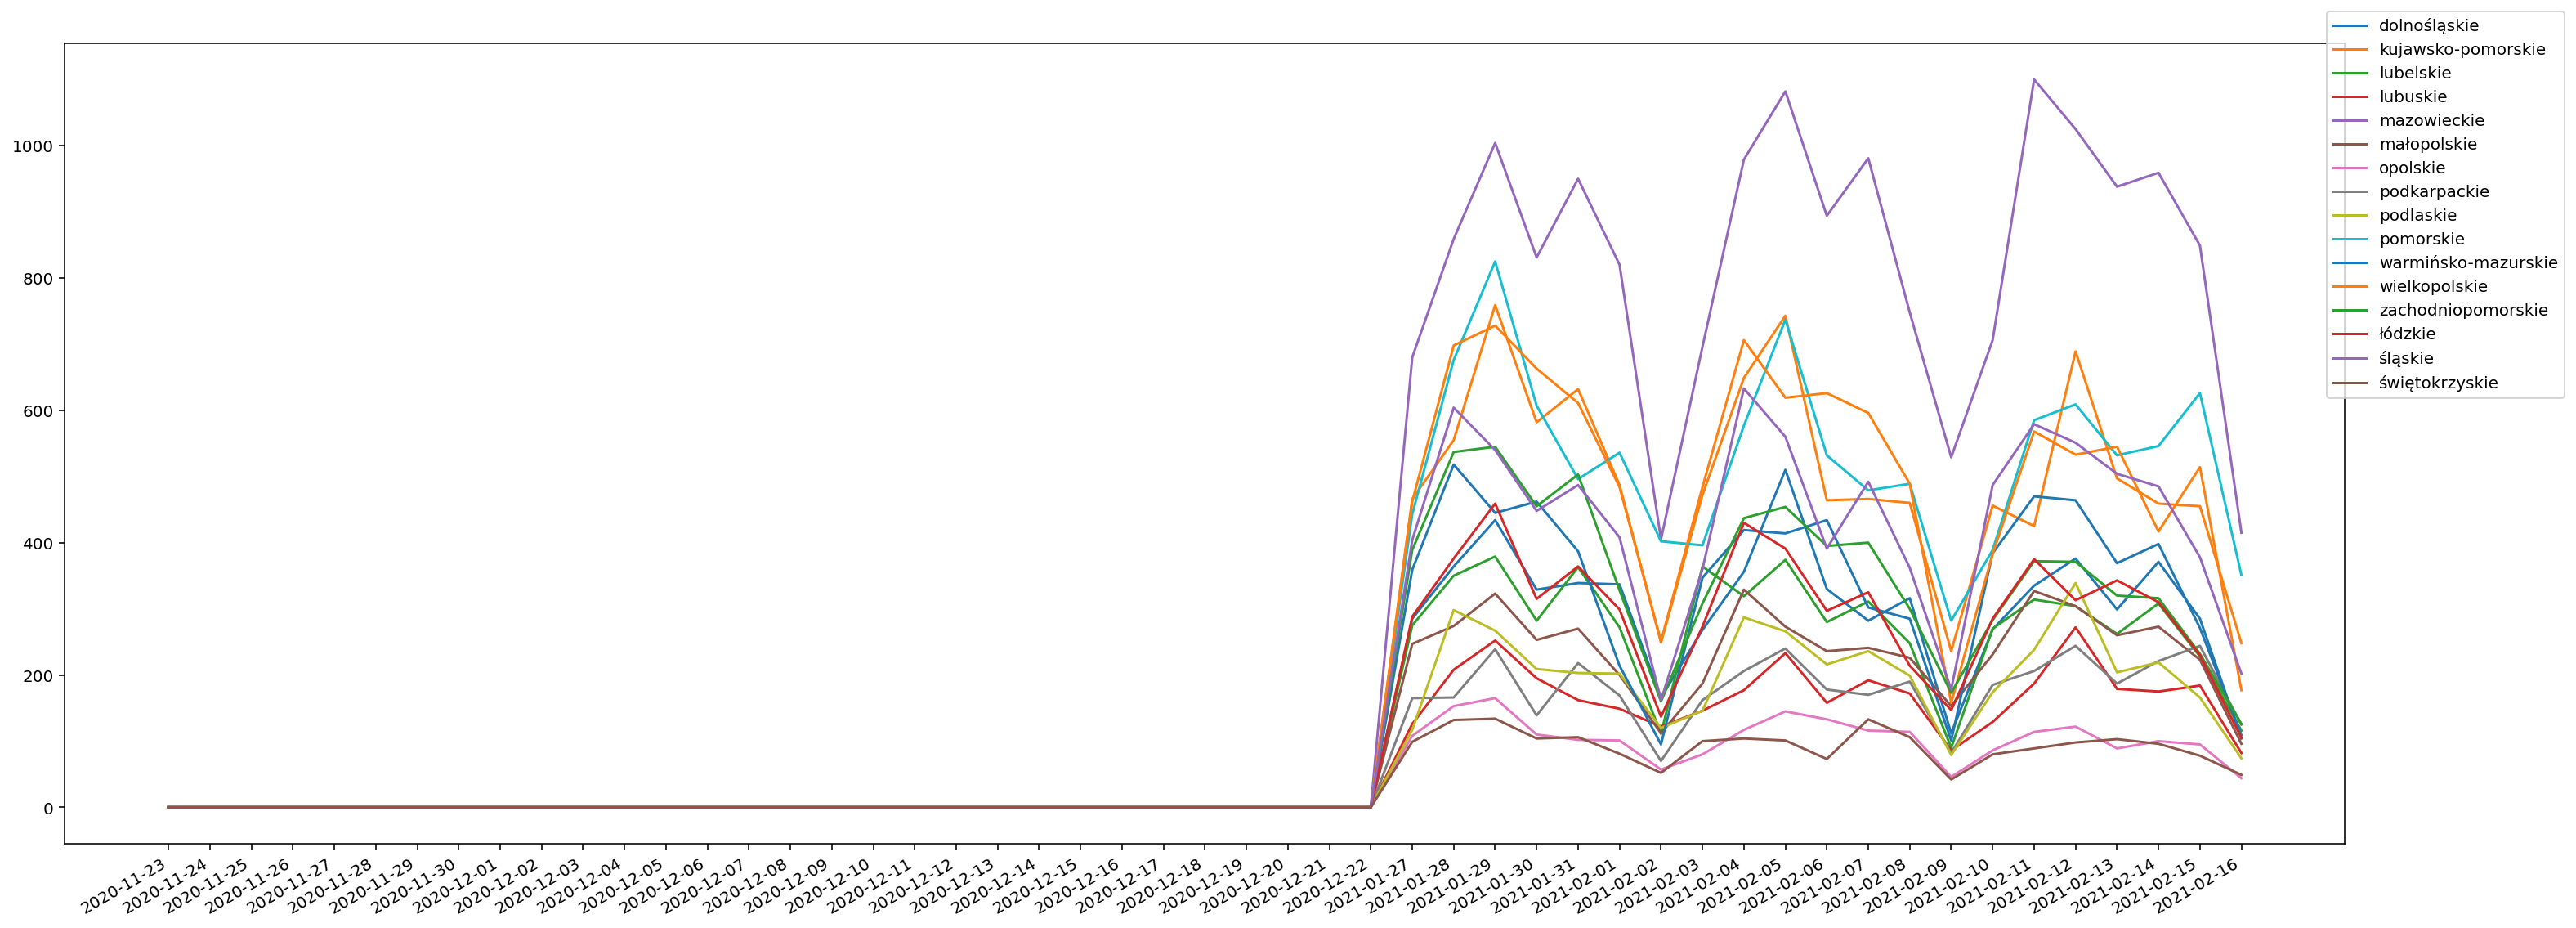

In [26]:
wojewodztwo_line_plot(pl_powiaty_merged, 'liczba_ozdrowiencow')

## Zgony

C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


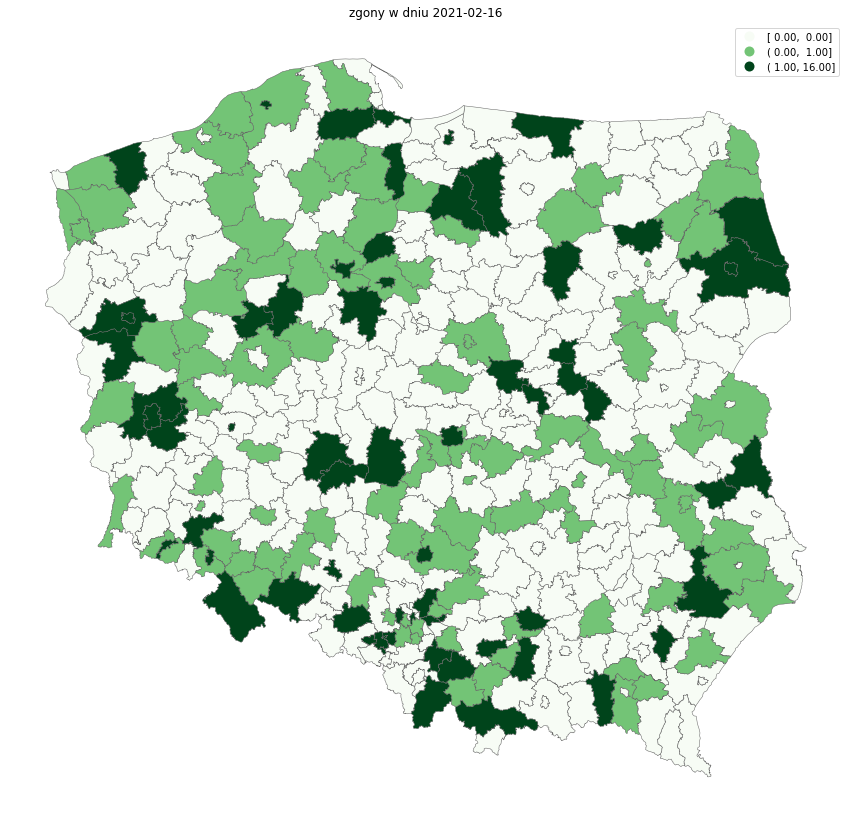

In [27]:
map_vis(pl_powiaty_merged, 'zgony', '2021-02-16')

C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % k_q, UserWarning)
C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Filip\anaconda3\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


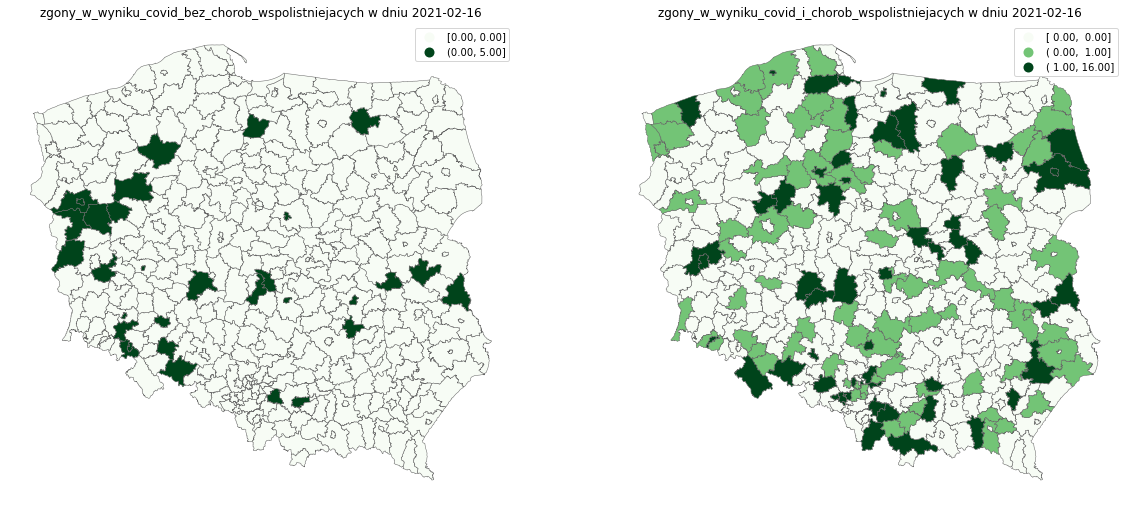

In [28]:
map_vis_cmp_columns(
    pl_powiaty_merged, 
    'zgony_w_wyniku_covid_bez_chorob_wspolistniejacych', 
    'zgony_w_wyniku_covid_i_chorob_wspolistniejacych', 
    '2021-02-16')

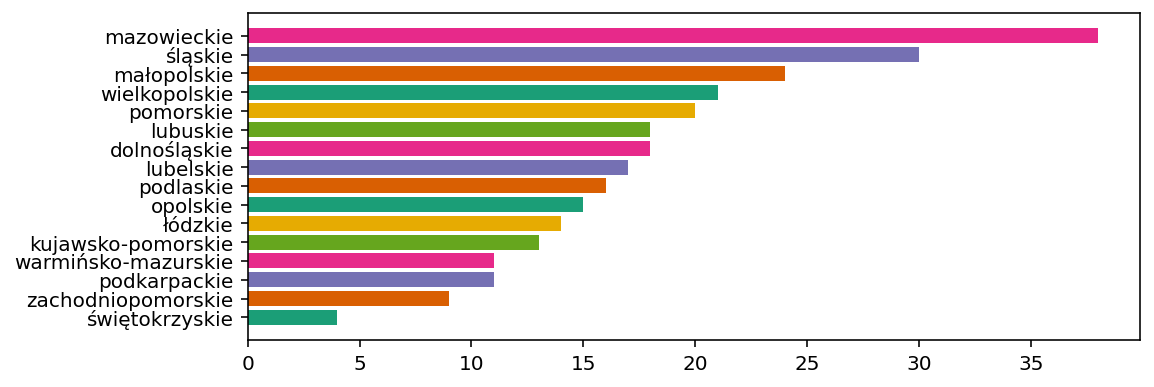

In [29]:
bar_plot_wojewodztwa(pl_powiaty_merged, 'zgony', '2021-02-16')

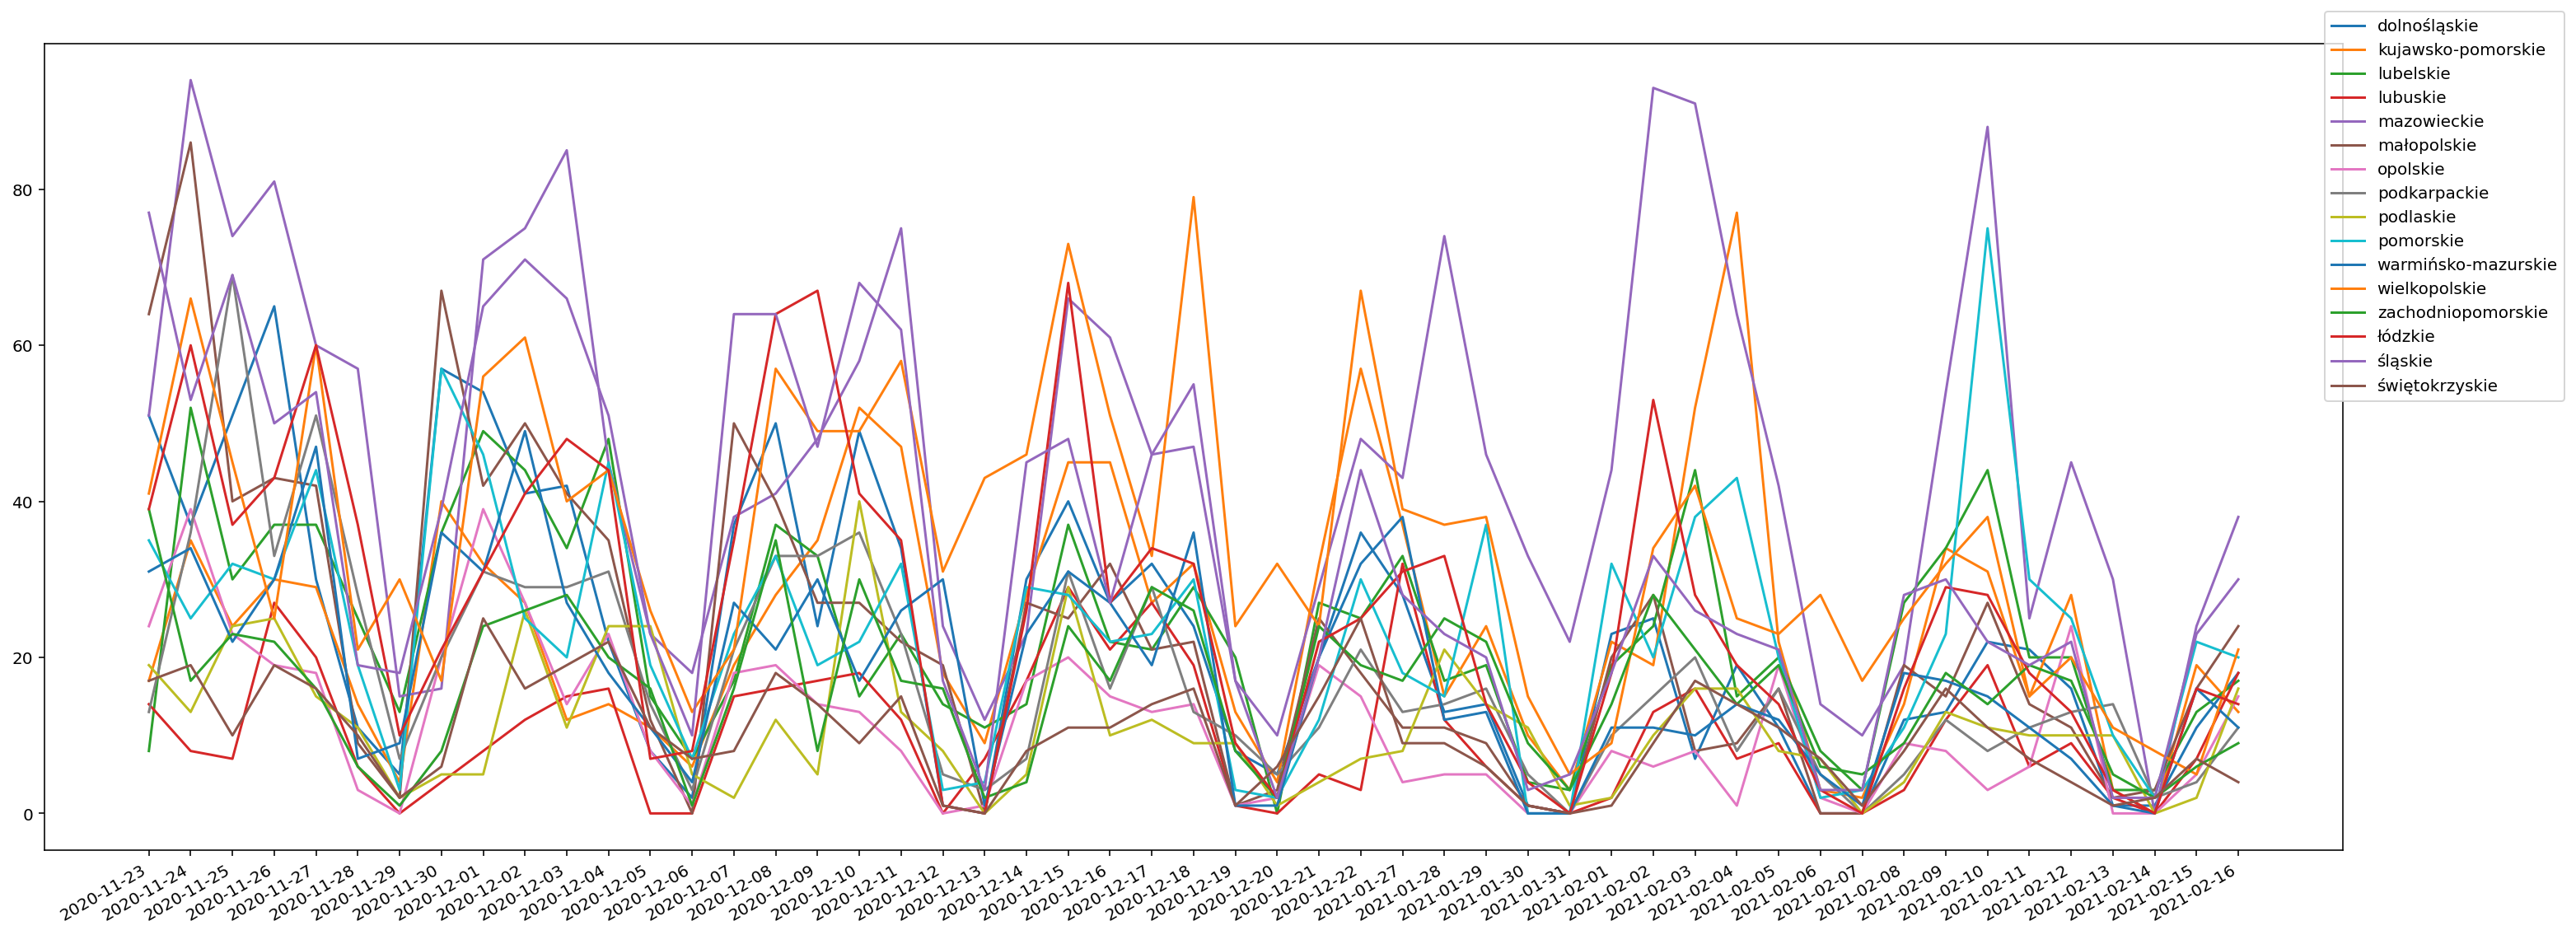

In [30]:
wojewodztwo_line_plot(pl_powiaty_merged, 'zgony')

# Podsumowanie

Projekt przedstawia wizualizacje danych statystycznych na temat korona wirusa w Polsce.

Uzyte w projekcie mapy pozwalaja na lepsze zwizualizowanie obszarow dotknietych epidemia